In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import re
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from Common.functions import evaluate_model, train_model
from Common.custom_dataset import CustomDataset
from Common.ffnn import FFNN
from Common.rnn import RNN


[nltk_data] Downloading package punkt to /Users/ali/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ali/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ali/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Import Dataset

In [2]:
# Load the train set
train_data = pd.read_csv("../Data/arxiv_train.csv")
print("\nShape of X_train:", train_data.shape)
print(f"\n{train_data.head(5)}")


Shape of X_train: (80000, 3)

   Unnamed: 0                                           abstract     label
0       31716    Automatic meeting analysis is an essential f...      eess
1       89533    We propose a protocol to encode classical bi...  quant-ph
2       82700    A number of physically intuitive results for...  quant-ph
3       78830    In the last decade rare-earth hexaborides ha...   physics
4       94948    We introduce the weak barycenter of a family...      stat


In [3]:
# Load the train set
test_data = pd.read_csv("../Data/arxiv_test.csv")
print("Shape of X_test:", test_data.shape)
print(f"\n{test_data.head(5)}")

Shape of X_test: (20000, 3)

   Unnamed: 0                                           abstract   label
0       64481    We describe a shape derivative approach to p...    math
1       48104    We study displaced signatures of sneutrino p...  hep-ph
2       48233    High precision studies of Beyond-Standard-Mo...  hep-ph
3       49026    We find that a class of models of MeV-GeV da...  hep-ph
4       37957    Knowledge of power grid's topology during ca...    eess


### Data Cleaning

In [4]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    tokens = word_tokenize(text.lower())  # Tokenize the text
    stop_words = set(stopwords.words('english'))  # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()  # Lemmatize each word
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    stemmer = PorterStemmer()  # Stem each word
    tokens = [stemmer.stem(word) for word in tokens]
    clean_text = ' '.join(tokens)  # Join tokens back into a single string
    return clean_text

train_data['clean_abstract'] = train_data['abstract'].apply(clean_text)
test_data['clean_abstract'] = test_data['abstract'].apply(clean_text)


In [5]:
train_data.head(5)

,Unnamed: 0,abstract,label,clean_abstract
0,31716,Automatic meeting analysis is an essential f...,eess,automat meet analysi essenti fundament technol...
1,89533,We propose a protocol to encode classical bi...,quant-ph,propos protocol encod classic bit measur stati...
2,82700,A number of physically intuitive results for...,quant-ph,number physic intuit result calcul multitim co...
3,78830,In the last decade rare-earth hexaborides ha...,physics,last decad rareearth hexaborid investig fundam...
4,94948,We introduce the weak barycenter of a family...,stat,introduc weak barycent famili probabl distribu...


In [6]:
research_fields = sorted(train_data["label"].unique())

print("Research Fields")
for i, element in enumerate(research_fields, start=1):
    print(f"{i}. {element}")

Research Fields
1. astro-ph
2. cond-mat
3. cs
4. eess
5. hep-ph
6. hep-th
7. math
8. physics
9. quant-ph
10. stat


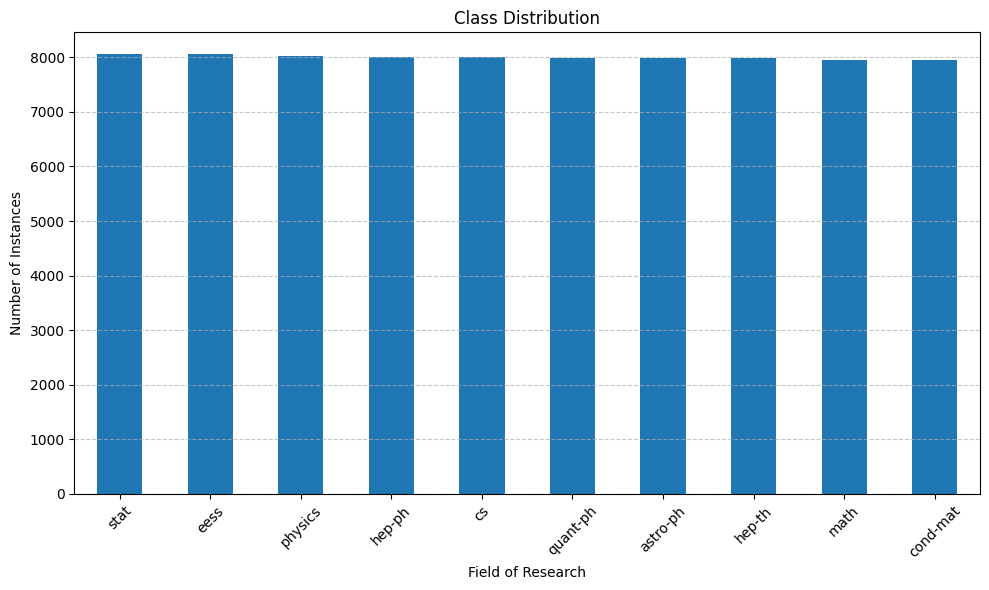

In [7]:
# Calculate class distribution
class_distribution = train_data['label'].value_counts()

# Plot class distribution
plt.figure(figsize=(10, 6))
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Field of Research')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

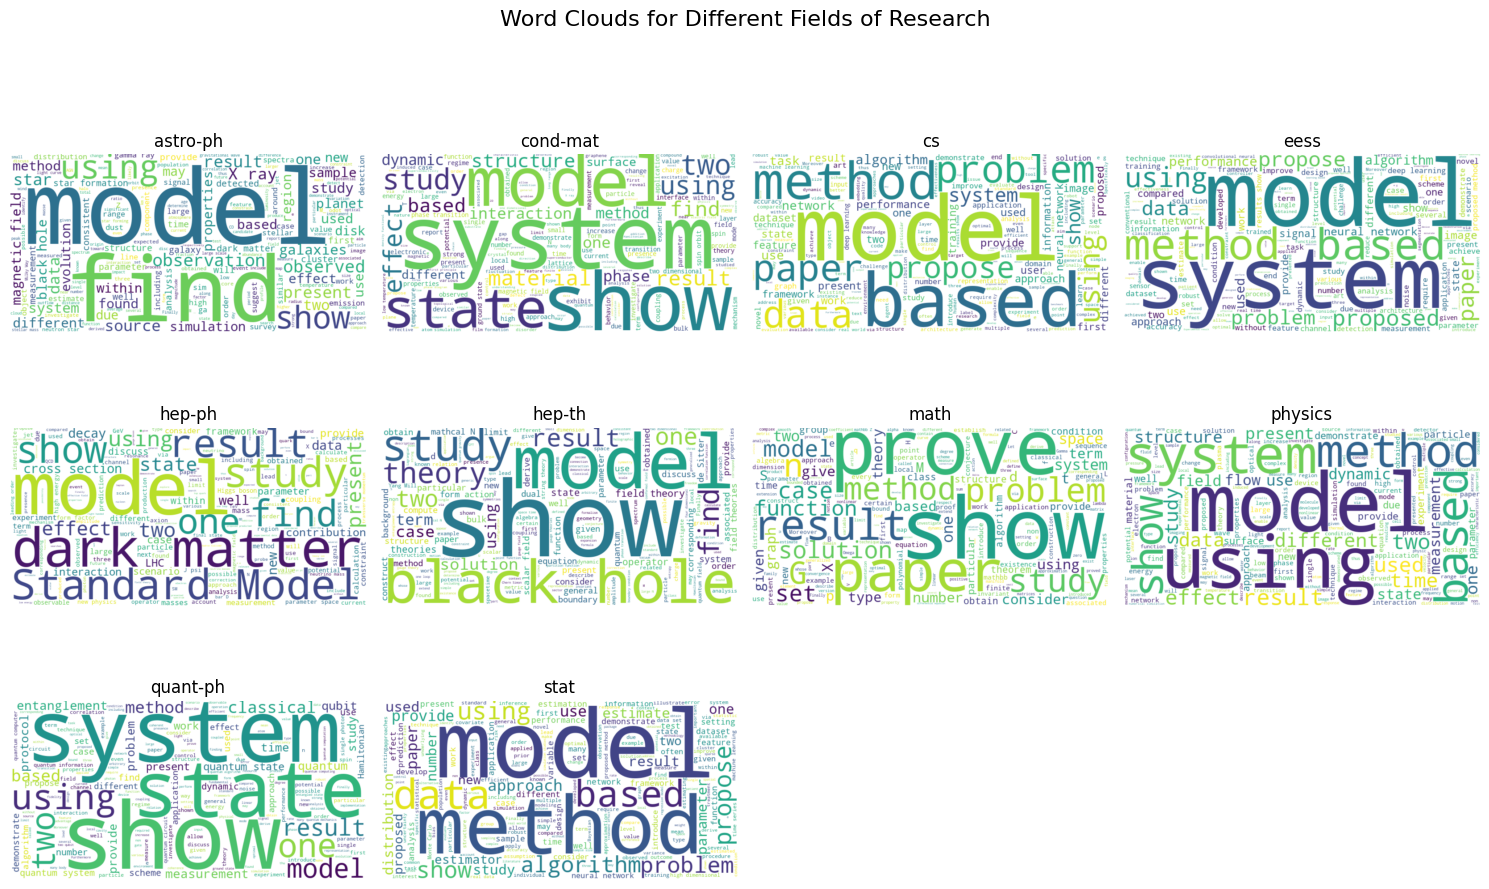

In [8]:
# Concatenate abstracts based on class labels
abstracts_by_class = {}
for label, group in train_data.groupby('label'):
    abstracts_by_class[label] = ' '.join(group['abstract'])

# Generate and plot word clouds for each class
plt.figure(figsize=(15, 10))
for i, (label, abstracts) in enumerate(abstracts_by_class.items(), start=1):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(abstracts)
    plt.subplot(3, 4, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(label)
    plt.axis('off')
plt.suptitle('Word Clouds for Different Fields of Research', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


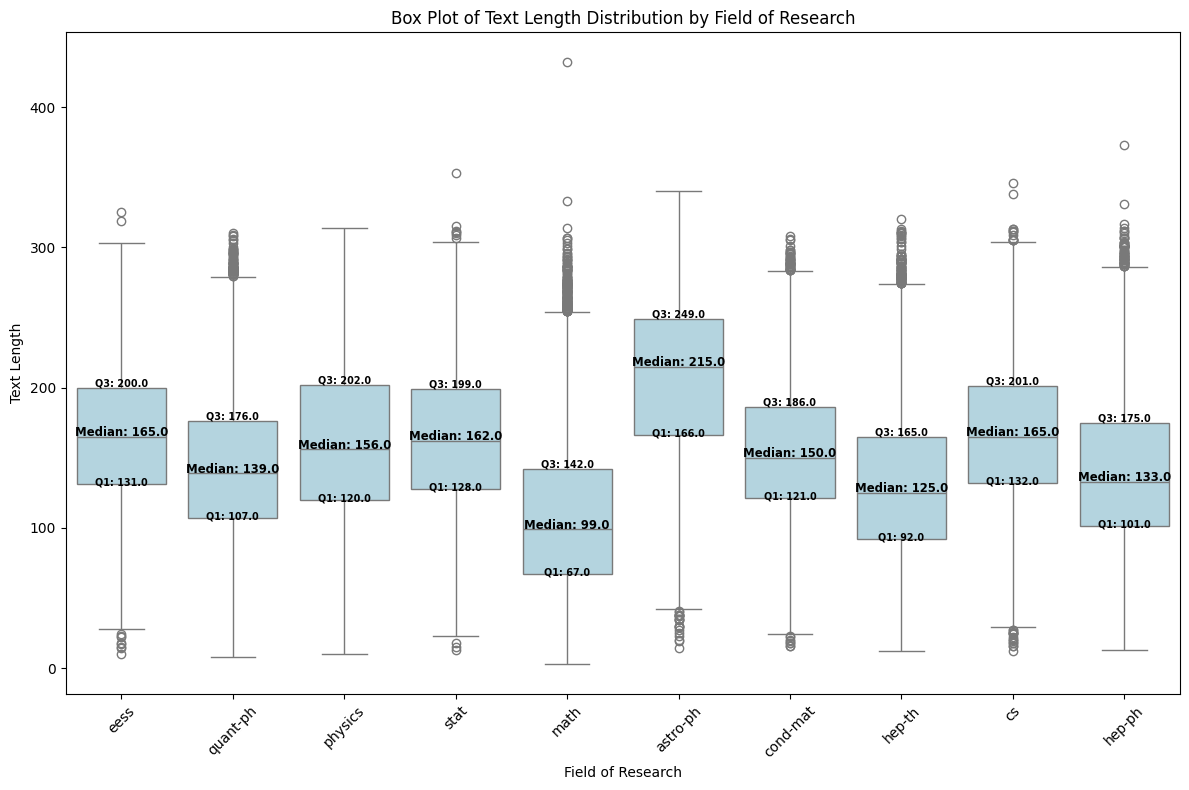

In [9]:
# Calculate text lengths if not already calculated
if 'text_length' not in train_data.columns:
    train_data['text_length'] = train_data['abstract'].apply(lambda x: len(x.split()))

# Calculate medians and quartiles if not already calculated
if 'medians' not in locals() or 'quartiles' not in locals():
    medians = train_data.groupby('label')['text_length'].median()
    quartiles = train_data.groupby('label')['text_length'].quantile([0.25, 0.75]).unstack(level=1)

# Plotting Box Plot
plt.figure(figsize=(12, 8))
box = sns.boxplot(data=train_data, x='label', y='text_length', color='lightblue')
plt.xticks(rotation=45)  # Helps if labels overlap or are too long

# Annotate with median, Q1, and Q3 values
labels = train_data['label'].unique()
for i, label in enumerate(labels):
    median = medians.loc[label]
    q1 = quartiles.loc[label][0.25]
    q3 = quartiles.loc[label][0.75]

    # Display median
    box.text(i, median + 0.5, f'Median: {median}', horizontalalignment='center', size='small', color='black', weight='semibold')
    
    # Display Q1
    box.text(i, q1 - 1, f'Q1: {q1}', horizontalalignment='center', size='x-small', color='black', weight='semibold')
    
    # Display Q3
    box.text(i, q3 + 1, f'Q3: {q3}', horizontalalignment='center', size='x-small', color='black', weight='semibold')

plt.title('Box Plot of Text Length Distribution by Field of Research')
plt.xlabel('Field of Research')
plt.ylabel('Text Length')
plt.tight_layout()
plt.show()

In [10]:
# Define the bags-of-words representations
count_vectorizer = CountVectorizer(max_features=5000)  # Adjust max_features as needed
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed


In [11]:
# Convert abstracts into feature vectors
X_train_count = count_vectorizer.fit_transform(train_data['clean_abstract']).toarray()
X_test_count = count_vectorizer.transform(test_data['clean_abstract']).toarray()

In [12]:
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['clean_abstract']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test_data['clean_abstract']).toarray()


In [13]:
# Define the labels
label_encoder = {label: idx for idx, label in enumerate(train_data['label'].unique())}
train_data['label_encoded'] = train_data['label'].map(label_encoder)
test_data['label_encoded'] = test_data['label'].map(label_encoder)

In [14]:
# Convert labels to PyTorch tensors
y_train = torch.tensor(train_data['label_encoded'].values)
y_test = torch.tensor(test_data['label_encoded'].values)


In [15]:
# Define train and test datasets
train_dataset_count = CustomDataset(X_train_count, y_train)
test_dataset_count = CustomDataset(X_test_count, y_test)

train_dataset_tfidf = CustomDataset(X_train_tfidf, y_train)
test_dataset_tfidf = CustomDataset(X_test_tfidf, y_test)

# Define data loaders
train_loader_count = DataLoader(train_dataset_count, batch_size=64, shuffle=True)
test_loader_count = DataLoader(test_dataset_count, batch_size=64, shuffle=False)

train_loader_tfidf = DataLoader(train_dataset_tfidf, batch_size=64, shuffle=True)
test_loader_tfidf = DataLoader(test_dataset_tfidf, batch_size=64, shuffle=False)


# FFNN

In [16]:
ffnn_evaluation_result = []
activation_functions = [nn.LeakyReLU(), nn.ELU(), nn.Sigmoid(), nn.Softmax(dim=1)]
vectorizers = {
    'count': (X_train_count, train_loader_count, test_loader_count),
    'tfidf': (X_train_tfidf, train_loader_tfidf, test_loader_tfidf)
}
layer_configs = [1, 2, 3]

### Evaluating different number of layers for CountVectorizer and TFIDF feature detection method


In [17]:
def train_and_evaluate_model(vectorizer_name, input_size, output_size, layers, train_loader, test_loader):
    print(f"Training FFNN with {vectorizer_name} and {layers} layers")
    model = FFNN(input_size, 256, output_size, layers)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_model(model, criterion, optimizer, train_loader, num_epochs=10)
    results = evaluate_model(model, test_loader, f"{vectorizer_name[:2].upper()}_L{layers}")
    ffnn_evaluation_result.append(results)

for vectorizer, data in vectorizers.items():
    input_size = data[0].shape[1]
    output_size = len(label_encoder)
    
    for layers in layer_configs:
        train_and_evaluate_model(vectorizer, input_size, output_size, layers, data[1], data[2])


Training FFNN with count and 1 layers


Training Progress: 100%|██████████|[00:36, Epoch=10, Loss=1114.33]


+-----------+-------+
|   Metric  | Score |
+-----------+-------+
|  Accuracy | 0.76% |
|  F1 Score | 0.73% |
| Precision | 0.70% |
|   Recall  | 0.76% |
+-----------+-------+
Training FFNN with count and 2 layers


Training Progress:  20%|██        |[00:10, Epoch=2, Loss=1017.49]


KeyboardInterrupt: 

### Evaluating Activation Functions for CountVectorizer and TFIDF feature detection method

In [38]:
def train_and_evaluate_ffnn(vectorizer_name, input_size, output_size, train_loader, test_loader, activation_functions):
    for activation_function in activation_functions:
        activation_name = activation_function.__class__.__name__
        print(f"Training FFNN with {vectorizer_name} and {activation_name} as an activation function\n")
        tag = f"{vectorizer_name[:2].upper()}_{activation_name}"

        ffnn = FFNN(input_size, 256, output_size, num_layers=2, activation=activation_function)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(ffnn.parameters(), lr=0.001)

        train_model(ffnn, criterion, optimizer, train_loader, num_epochs=10)
        results = evaluate_model(ffnn, test_loader, tag)
        ffnn_evaluation_result.append(results)
        

# Parameters for CountVectorizer
input_size_count = X_train_count.shape[1]
output_size_count = len(label_encoder)
train_and_evaluate_ffnn("CountVectorizer", input_size_count, output_size_count, train_loader_count, test_loader_count, activation_functions)

# Parameters for TFIDF
input_size_tfidf = X_train_tfidf.shape[1]
output_size_tfidf = len(label_encoder)
train_and_evaluate_ffnn("TFIDF", input_size_tfidf, output_size_tfidf, train_loader_tfidf, test_loader_tfidf, activation_functions)

Training FFNN with CountVectorizer and LeakyReLU as an activation function

Epoch [1/10], Loss: 744.7862123996019
Epoch [2/10], Loss: 459.4450418353081
Epoch [3/10], Loss: 296.82953307032585
Epoch [4/10], Loss: 155.78574704751372
Epoch [5/10], Loss: 67.38353470247239
Epoch [6/10], Loss: 25.99358341214247
Epoch [7/10], Loss: 13.11260117427446
Epoch [8/10], Loss: 12.138466039672494
Epoch [9/10], Loss: 16.09577255079057
Epoch [10/10], Loss: 11.40009806395392

Evaluations:
Accuracy: 81.83%
F1 Score: 81.69%
Precision: 81.81%
Recall: 81.79%


Training FFNN with CountVectorizer and ELU as an activation function

Epoch [1/10], Loss: 733.3590844273567
Epoch [2/10], Loss: 494.51537385582924
Epoch [3/10], Loss: 393.9133060127497
Epoch [4/10], Loss: 303.73983366042376
Epoch [5/10], Loss: 217.08960296027362
Epoch [6/10], Loss: 138.9020684864372
Epoch [7/10], Loss: 78.28386446367949
Epoch [8/10], Loss: 41.35433111945167
Epoch [9/10], Loss: 22.11927048745565
Epoch [10/10], Loss: 12.718164014164358

E

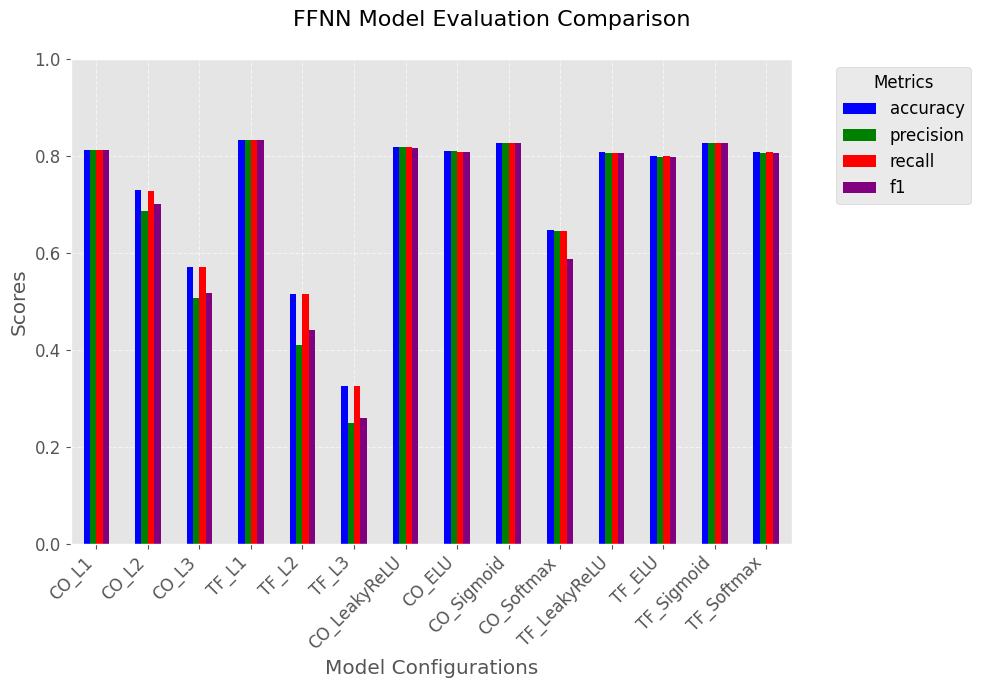

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Data preparation
df = pd.DataFrame(ffnn_evaluation_result)
df.set_index('tag', inplace=True)

# Styling and configuration
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12})

# Define custom colors for each metric, optional
color_dict = {'accuracy': 'blue', 'precision': 'green', 'recall': 'red', 'f1': 'purple'}

# Plotting
ax = df[['accuracy', 'precision', 'recall', 'f1']].plot(kind='bar', figsize=(10, 7), color=[color_dict.get(x) for x in ['accuracy', 'precision', 'recall', 'f1']])
ax.set_ylim(0, 1)
ax.set_xlabel('Model Configurations')
ax.set_ylabel('Scores')
ax.figure.suptitle('FFNN Model Evaluation Comparison', fontsize=16)
plt.xticks(rotation=45, ha='right')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Model for evaluating batch size


In [45]:
num_epochs = 10
learning_rate = 0.001
batch_sizes = [32, 64, 128, 256]

input_size_count = X_train_count.shape[1]
output_size_count = len(label_encoder)

for batch_size in batch_sizes:
    
    # Initialize model, criterion, and optimizer
    model = FFNN(input_size_count, 256, output_size_count, num_layers=2, activation=nn.ReLU())
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Prepare data loaders
    train_loader_count = DataLoader(train_dataset_count, batch_size, shuffle=True)
    test_loader_count = DataLoader(test_dataset_count, batch_size, shuffle=False)

    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader_count:
            optimizer.zero_grad()
            inputs = inputs.float()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Evaluate the model and store the result
    tag = f"Batch size: {batch_size}"
    evaluate_model(model, test_loader_count, tag)


Evaluating with batch size: 32

Evaluations:
Accuracy: 57.81%
F1 Score: 52.66%
Precision: 51.34%
Recall: 57.74%


Evaluating with batch size: 64

Evaluations:
Accuracy: 64.61%
F1 Score: 60.29%
Precision: 58.44%
Recall: 64.85%


Evaluating with batch size: 128

Evaluations:
Accuracy: 81.94%
F1 Score: 81.84%
Precision: 81.83%
Recall: 81.89%


Evaluating with batch size: 256

Evaluations:
Accuracy: 68.17%
F1 Score: 62.70%
Precision: 59.64%
Recall: 68.24%




In [54]:
def train_and_evaluate_model(input_size, output_size, train_dataset, test_dataset, vectorizer_name):
    num_epochs = 10
    learning_rate = 0.001
    batch_sizes = [32, 64, 128, 256]
    results = {}

    for batch_size in batch_sizes:
        
        # Initialize model, criterion, and optimizer
        model = FFNN(input_size, 256, output_size, num_layers=2, activation=nn.ReLU())
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Prepare data loaders
        train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

        for epoch in range(num_epochs):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                inputs = inputs.float()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            # Evaluate the model after training
            tag = f"{vectorizer_name}_batch_{batch_size}_epoch_{epoch}"
            evaluate_model(model, test_loader, tag)

input_size_count = X_train_count.shape[1]
output_size_count = len(label_encoder)
results_count = train_and_evaluate_model(input_size_count, output_size_count, train_dataset_count, test_dataset_count, "CountVectorizer")

input_size_tfidf = X_train_tfidf.shape[1]
results_tfidf = train_and_evaluate_model(input_size_tfidf, output_size_count, train_dataset_tfidf, test_dataset_tfidf, "TFIDF")


KeyboardInterrupt: 

# RNN


### Evaluating different number of layers for Count Vectorizer feature detection method

In [ ]:
# Train and evaluate RNN with CountVectorizer and different numbers of layers
input_size_count = X_train_count.shape[1]
output_size_count = len(label_encoder)
for num_layers in [1, 2, 3]:
    print(f"Training RNN with CountVectorizer and {num_layers} layers\n")
    
    rnn_count = RNN(input_size_count, 256, output_size_count, num_layers)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(rnn_count.parameters(), lr=0.001)
    
    train_model(rnn_count, criterion, optimizer, train_loader_count, num_epochs=10)
    evaluate_model(rnn_count, test_loader_count)

Training RNN with CountVectorizer and 1 layers

Epoch [1/10], Loss: 763.3199734687805
Epoch [2/10], Loss: 506.98329558968544
Epoch [3/10], Loss: 400.7188519388437
Epoch [4/10], Loss: 309.13360740989447
Epoch [5/10], Loss: 218.14016295969486
Epoch [6/10], Loss: 144.04848780483007
Epoch [7/10], Loss: 90.89709524437785
Epoch [8/10], Loss: 59.36363659566268
Epoch [9/10], Loss: 41.46178376721218
Epoch [10/10], Loss: 35.75288056908175

Evaluations:
Accuracy: 80.40%
F1 Score: 80.28%
Precision: 80.27%
Recall: 80.35%


Training RNN with CountVectorizer and 2 layers

Epoch [1/10], Loss: 780.1336170881987
Epoch [2/10], Loss: 533.3758004158735
Epoch [3/10], Loss: 448.5421806126833
Epoch [4/10], Loss: 380.02794320881367
Epoch [5/10], Loss: 317.9964202865958
Epoch [6/10], Loss: 259.1879898197949
Epoch [7/10], Loss: 205.02648516744375
Epoch [8/10], Loss: 160.85056117735803
Epoch [9/10], Loss: 123.30341439787298
Epoch [10/10], Loss: 95.95782375568524

Evaluations:
Accuracy: 79.81%
F1 Score: 79.86%
Pre

### Evaluating Different Activation Functions for Count Vectorizer feature detection method

In [ ]:
# Train and evaluate FFNN with CountVectorizer and different activation function
input_size_count = X_train_count.shape[1]
output_size_count = len(label_encoder)
activation_functions = [nn.LeakyReLU(), nn.ELU(), nn.Sigmoid(), nn.Softmax(dim=1)]

for activation_function in activation_functions:
    print(f"Training RNN with CountVectorizer and {activation_function.__class__.__name__} as an activation function\n")
    
    rnn_count = RNN(input_size_count, 256, output_size_count, num_layers=2, activation=activation_function)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(rnn_count.parameters(), lr=0.001)
    
    train_model(rnn_count, criterion, optimizer, train_loader_count, num_epochs=10)
    evaluate_model(rnn_count, test_loader_count)


Training RNN with CountVectorizer and LeakyReLU as an activation function

Epoch [1/10], Loss: 806.3141439259052
Epoch [2/10], Loss: 535.044398277998
Epoch [3/10], Loss: 451.13853193819523
Epoch [4/10], Loss: 383.09631638228893
Epoch [5/10], Loss: 322.45223496854305
Epoch [6/10], Loss: 265.23423055931926
Epoch [7/10], Loss: 211.11417189612985
Epoch [8/10], Loss: 161.5899314135313
Epoch [9/10], Loss: 128.69750709366053
Epoch [10/10], Loss: 98.5733313281089

Evaluations:
Accuracy: 80.27%
F1 Score: 80.25%
Precision: 80.51%
Recall: 80.26%


Training RNN with CountVectorizer and ELU as an activation function

Epoch [1/10], Loss: 785.3260654062033
Epoch [2/10], Loss: 536.790642619133
Epoch [3/10], Loss: 449.99404802173376
Epoch [4/10], Loss: 382.0542240664363
Epoch [5/10], Loss: 322.22879678756
Epoch [6/10], Loss: 263.0231476314366
Epoch [7/10], Loss: 208.42247082665563
Epoch [8/10], Loss: 161.14629240706563
Epoch [9/10], Loss: 126.28357488056645
Epoch [10/10], Loss: 99.38592691207305

Evalu

### Evaluating different number of layers for tfidf feature detection method

In [ ]:
input_size_tfidf = X_train_tfidf.shape[1]
output_size_tfidf = len(label_encoder)
for num_layers in [1, 2, 3]:
    print(f"Training RNN with TF-IDF and {num_layers} layers\n")
    
    rnn_tfidf = RNN(input_size_tfidf, 256, output_size_tfidf, num_layers)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(rnn_tfidf.parameters(), lr=0.001)
    
    train_model(rnn_tfidf, criterion, optimizer, train_loader_tfidf, num_epochs=10)
    evaluate_model(rnn_tfidf, test_loader_tfidf)

Training RNN with TF-IDF and 1 layers

Epoch [1/10], Loss: 974.9493601024151
Epoch [2/10], Loss: 560.0621326118708
Epoch [3/10], Loss: 495.56233832240105
Epoch [4/10], Loss: 459.116337954998
Epoch [5/10], Loss: 432.02958865463734
Epoch [6/10], Loss: 412.2890088185668
Epoch [7/10], Loss: 397.56641874462366
Epoch [8/10], Loss: 384.2523663341999
Epoch [9/10], Loss: 375.58368457853794
Epoch [10/10], Loss: 364.91814502328634

Evaluations:
Accuracy: 79.35%
F1 Score: 79.27%
Precision: 79.29%
Recall: 79.32%


Training RNN with TF-IDF and 2 layers

Epoch [1/10], Loss: 944.0967095196247
Epoch [2/10], Loss: 586.5105360001326
Epoch [3/10], Loss: 524.6750490069389
Epoch [4/10], Loss: 484.3246194422245
Epoch [5/10], Loss: 457.8491253107786
Epoch [6/10], Loss: 432.71689858287573
Epoch [7/10], Loss: 417.4559953585267
Epoch [8/10], Loss: 405.78441286087036
Epoch [9/10], Loss: 391.60116408765316
Epoch [10/10], Loss: 376.27822683006525

Evaluations:
Accuracy: 79.81%
F1 Score: 79.65%
Precision: 79.93%
Rec

### Evaluating Activation Function for tfidf feature detection method

In [ ]:
input_size_tfidf = X_train_tfidf.shape[1]
output_size_tfidf = len(label_encoder)
activation_functions = [nn.LeakyReLU(), nn.ELU(), nn.Sigmoid(), nn.Softmax(dim=1)]

for activation_function in activation_functions:
    print(f"Training RNN with tfidf and {activation_function.__class__.__name__} as an activation function\n")
    
    rnn_tfidf = RNN(input_size_tfidf, 256, output_size_tfidf, num_layers=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(rnn_tfidf.parameters(), lr=0.001)
    
    train_model(rnn_tfidf, criterion, optimizer, train_loader_tfidf, num_epochs=10)
    evaluate_model(rnn_tfidf, test_loader_tfidf)

Training RNN with tfidf and LeakyReLU as an activation function

Epoch [1/10], Loss: 959.5855261832476
Epoch [2/10], Loss: 586.7226179987192
Epoch [3/10], Loss: 520.5368458628654
Epoch [4/10], Loss: 482.04027332365513
Epoch [5/10], Loss: 456.0838768184185
Epoch [6/10], Loss: 435.62667295336723
Epoch [7/10], Loss: 418.85956501215696
Epoch [8/10], Loss: 405.2117108106613
Epoch [9/10], Loss: 389.3891863003373
Epoch [10/10], Loss: 380.1468401700258

Evaluations:
Accuracy: 79.97%
F1 Score: 79.87%
Precision: 79.95%
Recall: 79.90%


Training RNN with tfidf and ELU as an activation function

Epoch [1/10], Loss: 930.935423463583
Epoch [2/10], Loss: 590.0360115617514
Epoch [3/10], Loss: 524.5577806830406
Epoch [4/10], Loss: 484.2687980681658
Epoch [5/10], Loss: 459.3589107468724
Epoch [6/10], Loss: 436.2060491144657
Epoch [7/10], Loss: 417.8359133377671
Epoch [8/10], Loss: 405.26593001931906
Epoch [9/10], Loss: 392.54777332395315
Epoch [10/10], Loss: 378.93930273503065

Evaluations:
Accuracy: 80

### Evaluating hidden size

In [ ]:

class RNN_hidden_size(nn.Module):
    def __init__(
        self, input_size, hidden_sizes, output_size, activation=nn.ReLU()
    ):
        super(RNN_hidden_size, self).__init__()
        self.num_layers = len(hidden_sizes) + 1
        self.hidden_layers = nn.ModuleList()
        for i in range(self.num_layers - 1):
            if i == 0:
                self.hidden_layers.append(nn.Linear(input_size, hidden_sizes[i]))
            else:
                self.hidden_layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.hidden_layers.append(activation)
        self.hidden_layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        return x